# Here we train a GAN to add details to the upsampled images by cubic interpolation

In [8]:
from ProbaData import *

from SuperResGanModel import SuperResolutionGan

import tensorflow as tf
import time

from IPython.display import clear_output

In [9]:
data_dir = "DataGenerated/"
ds = ProbaVDataset("DataGenerated/")

In [ ]:
BUFFER_SIZE = 1500
batch_size = 2

train_dataset = tf.data.Dataset.list_files(data_dir +  "train/*/*/all.png")
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(ds.load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)

In [ ]:
dev_dataset = tf.data.Dataset.list_files(data_dir +  "dev/*/*/all.png")
dev_dataset = dev_dataset.map(ds.load_train_image)
dev_dataset = dev_dataset.batch(batch_size)

In [ ]:
test_dataset = tf.data.Dataset.list_files(data_dir +  "test/*/*/up_LR.png")
test_dataset = test_dataset.map(ds.load_test_image)
test_dataset = test_dataset.batch(1)

In [6]:
srg = SuperResolutionGan()

tf.Tensor([[0.49999934]], shape=(1, 1), dtype=float32)


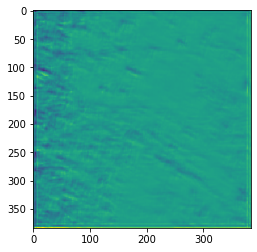

In [7]:
test_output = srg.srg(ds.load_train_image("DataGenerated/train/RED/imgset0478/LR_HR_SM.png")[0][tf.newaxis,...], training=False)
plt.imshow(test_output[0][0][:,:,0])
print(test_output[1])

In [8]:
def maskedScaledMSE(hr, sm, sr):
    pass
    #TODO

In [9]:
from tensorflow.keras.optimizers import Adam
binary_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 100

In [10]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = binary_loss(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = binary_loss(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [11]:
def generator_loss(disc_output, gen_output, hr):
    # we try to trick the discriminator to predict our generated image to be considered as valid ([1])
    gan_loss = binary_loss(tf.ones_like(disc_output), disc_output)
    
    # We also want the image to look as similar as possible to the HR images
    # TODO use maskedScaledMSE or MAE
    l1_loss = tf.reduce_mean(tf.abs(hr - gen_output))
    #  [32,384,384,1], [32,1]
    
    # Lambda controls how much we value each loss
    return gan_loss + (LAMBDA * l1_loss)

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Checkpoints

In [13]:
checkpoint_dir = './TrainingCheckpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=srg.generator,
                                 discriminator=srg.discriminator)

In [15]:
EPOCHS = 5000

In [16]:
@tf.function
def compute_loss(lr, hr):
    # Get generator output
    gen_output = srg.generator(lr, training=True)

    # Get discriminator output for the real image and the super resolved image
    disc_real_output = srg.discriminator(hr, training=True)
    disc_generated_output = srg.discriminator(gen_output, training=True)

    # Compute losses for each network using above functions
    gen_loss = generator_loss(disc_generated_output, gen_output, hr)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    return gen_loss, disc_loss

In [17]:
@tf.function
def train_step(lr, hr):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_loss, disc_loss = compute_loss(lr, hr)
        # We compute gradient for each part
        generator_gradients = gen_tape.gradient(gen_loss, srg.generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, srg.discriminator.trainable_variables)

        # We apply the gradient to the variables, tf2.0 way
        generator_optimizer.apply_gradients(zip(generator_gradients, srg.generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, srg.discriminator.trainable_variables))

In [18]:
def show_test_pred(generator, up_LR):
    predicted = generator.predict(up_LR)
    plt.figure(figsize=(15,15))
    
    display_list = [up_LR[0], predicted[0]]
    title = ['Input Image', 'Predicted Image']
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i][:,:,0])
        plt.axis('off')
    plt.show()
    

In [19]:
def show_dev_pred(generator, lr, hr):
    predicted = generator.predict(lr)
    plt.figure(figsize=(15,15))
    
    display_list = [lr[0][:,:,0], predicted[0][:,:,0], hr[0][:,:,0]]
    title = ['Input Image', 'Predicted Image', 'Real image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()
    

In [20]:
dev_disc_losses = []
dev_gen_losses = []

def train(train_dataset, dev_dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for lr, hr, sm in train_dataset:
            train_step(lr, hr)
            
        clear_output(wait=True)
        for lr, hr, sm in dev_dataset.take(1):
            show_dev_pred(srg.generator, lr, hr)
            
        disc_loss = 0
        gen_loss = 0
        for lr, hr, sm in dev_dataset:
            g_l, d_l = compute_loss(lr, hr)
            disc_loss += d_l
            gen_loss += g_l

        dev_disc_losses.append(disc_loss)
        dev_gen_losses.append(gen_loss)
        
        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 1 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        if (epoch + 1) % 5 == 0:
            print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
            print('current losses: (gen / disc) ' + str(gen_loss.numpy()) + "/" + str(disc_loss.numpy()))
            print('=============================================')

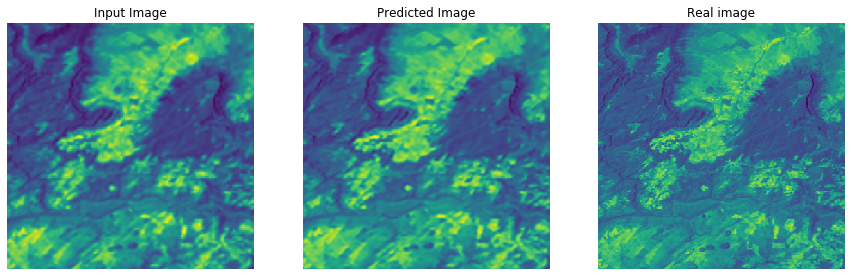

KeyboardInterrupt: 

In [21]:
train(train_dataset, dev_dataset, EPOCHS)

In [22]:
len(dev_disc_losses)

99

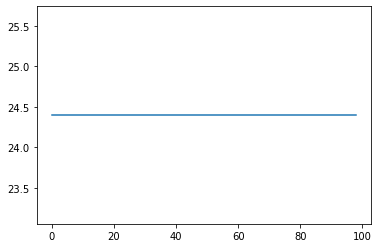

In [23]:
plt.plot(dev_disc_losses)

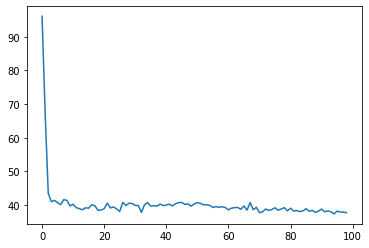

In [25]:
plt.plot(dev_gen_losses)